# Uso de rede convolucional para classificação de áudios a partir de imagens de mel espectogramas


## Gerando e salvando espectogramas das músicas


In [ ]:
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import imageio

root_dir = 'Data/genres_original'
output_dir = 'spectrograms'

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


n_mels = 128
hop_length = 512
n_fft = 2048
segment_duration = 3
images = []
labels = []
for genre in genres:
    genre_dir = os.path.join(root_dir, genre)
    label = genre
    print(genre)
    for filename in os.listdir(genre_dir):
        audio_path = os.path.join(genre_dir, filename)
        try:
          y, sr = librosa.load(audio_path)

          segment_length = segment_duration * sr
          n_samples = len(y)
          for i in range(10):
              start_sample = np.random.randint(0, n_samples - segment_length)
              end_sample = int(start_sample + segment_length)
              segment = y[start_sample:end_sample]

              mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels,
                                                        hop_length=hop_length, n_fft=n_fft)
              log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
              images.append(log_mel_spec)
              labels.append(label)
        except:
          print("Erro em "+audio_path)

print("Espectrogramas gerados e salvos com sucesso!")


blues
classical
country
disco
hiphop
jazz


<ipython-input-5-1bee760e6e01>:27: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Erro em Data/genres_original/jazz/jazz.00054.wav
metal
pop
reggae
rock
Espectrogramas gerados e salvos com sucesso!


In [ ]:
import pandas as pd
data = {'Spectrograms': images, 'Labels': labels}
df = pd.DataFrame(data)
df.head()

,Spectrograms,Labels
0,"[[-41.969704, -48.07244, -60.053627, -58.94497...",blues
1,"[[-54.922012, -39.966877, -34.131905, -35.4176...",blues
2,"[[-57.09285, -59.500156, -65.74443, -61.532585...",blues
3,"[[-42.97397, -47.937786, -52.000134, -51.36960...",blues
4,"[[-42.037685, -45.372467, -50.727077, -53.0831...",blues


## Exemplo de espectograma


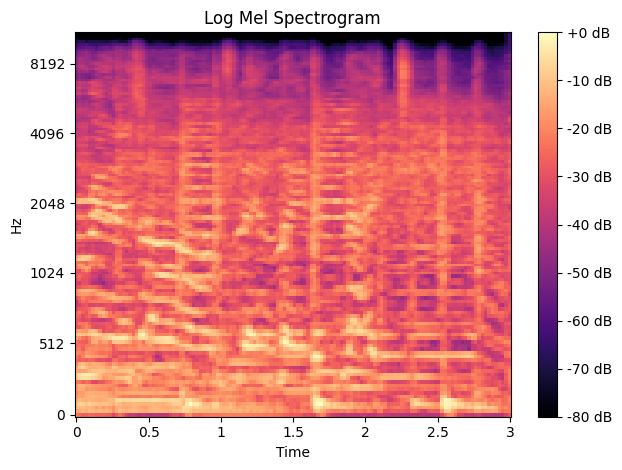

In [ ]:
y, sr = librosa.load(audio_path, duration=segment_duration)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.tight_layout()
plt.show()


## Treinamento e avaliação de diferentes topólogias de redes


In [ ]:
import numpy as np
import os
import cv2
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
segment_duration = 30
n_mels = 128
hop_length = 512
n_fft = 1024


In [ ]:
images = np.array(df['Spectrograms'].tolist())
labels = df['Labels'].tolist()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)


In [ ]:
model = Sequential([
    Conv2D(16, (7, 7), activation='relu', input_shape=(n_mels, X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')  # Camada de saída
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
225/225 [==============================] - 188s 826ms/step - loss: 2.3334 - accuracy: 0.0984 - val_loss: 2.3030 - val_accuracy: 0.0887
Epoch 2/10
225/225 [==============================] - 186s 826ms/step - loss: 2.3027 - accuracy: 0.1030 - val_loss: 2.3032 - val_accuracy: 0.0887
Epoch 3/10
225/225 [==============================] - 187s 830ms/step - loss: 2.3027 - accuracy: 0.1030 - val_loss: 2.3035 - val_accuracy: 0.0887
Epoch 4/10
225/225 [==============================] - 194s 859ms/step - loss: 2.3027 - accuracy: 0.1030 - val_loss: 2.3033 - val_accuracy: 0.0887
Epoch 5/10
225/225 [==============================] - 192s 856ms/step - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3035 - val_accuracy: 0.0887
Epoch 6/10
225/225 [==============================] - 194s 859ms/step - loss: 2.3027 - accuracy: 0.1030 - val_loss: 2.3035 - val_accuracy: 0.0887
Epoch 7/10
225/225 [==============================] - 187s 831ms/step - loss: 2.3027 - accuracy: 0.1011 - val_loss: 2.3036 -

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 12s 191ms/step - loss: 2.3031 - accuracy: 0.0941
Test accuracy: 0.09409409761428833


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
225/225 [==============================] - 269s 1s/step - loss: 2.4644 - accuracy: 0.1753 - val_loss: 1.9073 - val_accuracy: 0.3200
Epoch 2/10
225/225 [==============================] - 258s 1s/step - loss: 1.9126 - accuracy: 0.2988 - val_loss: 1.6963 - val_accuracy: 0.3925
Epoch 3/10
225/225 [==============================] - 263s 1s/step - loss: 1.8030 - accuracy: 0.3386 - val_loss: 1.6855 - val_accuracy: 0.3900
Epoch 4/10
225/225 [==============================] - 262s 1s/step - loss: 1.6481 - accuracy: 0.3939 - val_loss: 1.4574 - val_accuracy: 0.4975
Epoch 5/10
225/225 [==============================] - 260s 1s/step - loss: 1.5678 - accuracy: 0.4219 - val_loss: 1.4251 - val_accuracy: 0.4988
Epoch 6/10
225/225 [==============================] - 260s 1s/step - loss: 1.4998 - accuracy: 0.4575 - val_loss: 1.4104 - val_accuracy: 0.4988
Epoch 7/10
225/225 [==============================] - 262s 1s/step - loss: 1.4185 - accuracy: 0.4786 - val_loss: 1.2654 - val_accuracy: 0.5525

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 18s 278ms/step - loss: 1.1776 - accuracy: 0.5736
Test accuracy: 0.5735735893249512


In [ ]:
#df['Labels'] = pd.Categorical(df['Labels'])
#df['Labels'] = df.Labels.cat.codes

#l = df.pop('Labels')
dataset = tf.data.Dataset.from_tensor_slices((np.array(images), l.values))

In [ ]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [ ]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 130, 3)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 30, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1600)             

In [ ]:
import tensorflow as tf

In [ ]:
model = Sequential([
    Conv2D(32, (5, 5),1, activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D(),
    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 124, 126, 32)      832       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 62, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 61, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 57600)             0         
                                                                 
 dense_18 (Dense)            (None, 64)               

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
225/225 [==============================] - 6s 16ms/step - loss: 4.2443 - accuracy: 0.3152 - val_loss: 1.5380 - val_accuracy: 0.4425
Epoch 2/20
225/225 [==============================] - 3s 13ms/step - loss: 1.3862 - accuracy: 0.4860 - val_loss: 1.2778 - val_accuracy: 0.5175
Epoch 3/20
225/225 [==============================] - 3s 13ms/step - loss: 1.1699 - accuracy: 0.5652 - val_loss: 1.1349 - val_accuracy: 0.6050
Epoch 4/20
225/225 [==============================] - 3s 13ms/step - loss: 0.9225 - accuracy: 0.6585 - val_loss: 1.0444 - val_accuracy: 0.6513
Epoch 5/20
225/225 [==============================] - 3s 13ms/step - loss: 0.7569 - accuracy: 0.7229 - val_loss: 1.1817 - val_accuracy: 0.6050
Epoch 6/20
225/225 [==============================] - 3s 13ms/step - loss: 0.5926 - accuracy: 0.7845 - val_loss: 1.0747 - val_accuracy: 0.6725
Epoch 7/20
225/225 [==============================] - 3s 13ms/step - loss: 0.4456 - accuracy: 0.8404 - val_loss: 1.1618 - val_accuracy: 0.6400

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 8ms/step - loss: 2.6471 - accuracy: 0.6266
Test accuracy: 0.6266266107559204


In [ ]:
model1 = Sequential([
    Conv2D(32, (5, 5),1, activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D(),
    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),

    Dense(10, activation='softmax')
])
model1.summary()
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 126, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 32)                1

In [ ]:
model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
225/225 [==============================] - 15s 16ms/step - loss: 2.7242 - accuracy: 0.3098 - val_loss: 1.4313 - val_accuracy: 0.4850
Epoch 2/10
225/225 [==============================] - 3s 14ms/step - loss: 1.2250 - accuracy: 0.5715 - val_loss: 1.2907 - val_accuracy: 0.5587
Epoch 3/10
225/225 [==============================] - 3s 12ms/step - loss: 0.9000 - accuracy: 0.6853 - val_loss: 1.1498 - val_accuracy: 0.6112
Epoch 4/10
225/225 [==============================] - 3s 12ms/step - loss: 0.6856 - accuracy: 0.7592 - val_loss: 1.0642 - val_accuracy: 0.6350
Epoch 5/10
225/225 [==============================] - 3s 13ms/step - loss: 0.4384 - accuracy: 0.8546 - val_loss: 1.1062 - val_accuracy: 0.6525
Epoch 6/10
225/225 [==============================] - 3s 13ms/step - loss: 0.2934 - accuracy: 0.9050 - val_loss: 1.3085 - val_accuracy: 0.6450
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2153 - accuracy: 0.9271 - val_loss: 1.2525 - val_accuracy: 0.653

In [ ]:
test_loss, test_accuracy = model1.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 1s 7ms/step - loss: 1.7618 - accuracy: 0.6772
Test accuracy: 0.6771771907806396


In [ ]:
model2 = Sequential([
    Conv2D(32, (5, 5),1, activation='relu', input_shape=(128, 13, 1)),
    MaxPooling2D(),
    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
model2.summary()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 124, 9, 32)        832       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 4, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 2, 64)         18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 1, 64)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1920)              0         
                                                                 
 dense_23 (Dense)            (None, 256)              

In [ ]:
model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1124/1124 [==============================] - 7s 4ms/step - loss: 1.5678 - accuracy: 0.4542 - val_loss: 1.2186 - val_accuracy: 0.5651
Epoch 2/10
1124/1124 [==============================] - 5s 4ms/step - loss: 1.1311 - accuracy: 0.5997 - val_loss: 1.0940 - val_accuracy: 0.6176
Epoch 3/10
1124/1124 [==============================] - 5s 4ms/step - loss: 0.9436 - accuracy: 0.6698 - val_loss: 0.9653 - val_accuracy: 0.6687
Epoch 4/10
1124/1124 [==============================] - 4s 4ms/step - loss: 0.8090 - accuracy: 0.7150 - val_loss: 0.8751 - val_accuracy: 0.6909
Epoch 5/10
1124/1124 [==============================] - 6s 5ms/step - loss: 0.6831 - accuracy: 0.7605 - val_loss: 0.8772 - val_accuracy: 0.7102
Epoch 6/10
1124/1124 [==============================] - 5s 4ms/step - loss: 0.5839 - accuracy: 0.7940 - val_loss: 0.8535 - val_accuracy: 0.7150
Epoch 7/10
1124/1124 [==============================] - 4s 4ms/step - loss: 0.5009 - accuracy: 0.8226 - val_loss: 0.8451 - val_accuracy:

In [ ]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


313/313 [==============================] - 1s 3ms/step - loss: 1.0044 - accuracy: 0.7364
Test accuracy: 0.7364364266395569


In [ ]:
model2 = Sequential([
    Conv2D(32, (3, 3),1, activation='relu', input_shape=(128, 130, 1)),
    MaxPooling2D(),

    Conv2D(64, (3, 3),1, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),


    Dense(10, activation='softmax')
])
model2.summary()
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 126, 128, 32)      320       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 63, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 61, 62, 64)        18496     
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 30, 31, 64)       0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 59520)             0         
                                                                 
 dense_47 (Dense)            (None, 64)              

In [ ]:
model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

In [ ]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


63/63 [==============================] - 0s 6ms/step - loss: 1.9052 - accuracy: 0.6812
Test accuracy: 0.6811811923980713
